<a href="https://colab.research.google.com/github/henriqueburis/DML_constrative_faceRecognition/blob/main/face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Metric Learning
*. Contrastive Loss

fonte: https://kevinmusgrave.github.io/pytorch-metric-learning/

In [ ]:
!pip install pytorch_metric_learning
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 28.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85.5 MB 1.2 MB/s 


In [ ]:
!unzip /content/post-processed.zip
!unzip /content/inferencia.zip
!unzip /content/Novo.zip

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import argparse
from torchvision import datasets, transforms
from torchvision.io import read_image
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import os
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((256,256)), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

In [ ]:
dataset1 = datasets.ImageFolder(os.path.abspath('/content/post-processed'), transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,
                                          batch_size=32,
                                          shuffle=True)

In [ ]:
dataset2 = datasets.ImageFolder(os.path.abspath('/content/Novo'), transform=transform)
add_loader = torch.utils.data.DataLoader(dataset2, batch_size=1,
                                         shuffle=False)

In [ ]:
dataset3 = datasets.ImageFolder(os.path.abspath('/content/inferencia'), transform=transform)
inferencia_loader = torch.utils.data.DataLoader(dataset3, batch_size=1,
                                         shuffle=False)

Rede neural Resnet50 pré treinada, removendo a ultima camada para servir como extrator de features

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = models.resnet50(pretrained=True)
#Remove fully connected layer
modules = list(net.children())[:-1]
modules.append(nn.Flatten())
net = nn.Sequential(*modules)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model = net.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001) #original 0.01 
num_epochs = 20 #200

In [ ]:
def train(model, loss_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {} ".format(
                    epoch, batch_idx, loss
                )
            )

In [ ]:
### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

In [ ]:
def outputVetordescritor(train_set, model):
    test_embeddings, test_labels = get_all_embeddings(train_set, model)
    test_labels = test_labels.squeeze(1)
    return test_embeddings, test_labels

ContrastiveLoss função de perda do aprendizado métrico

A perda contrastiva, consiste em dois pontos $x_1$,$x_2$ algumas amostras no conjunto de dados e $y_1$,$y_2$ são seus rótulos correspondentes a função de perda é reunir diretamente as amostra semelhantes e afastar
as diferentes não semelhantes, dai o nome contrativa . A função de
perda é então definida na Equação

\begin{equation}
L_{contrast} = 1_{y1=y2}D^2_{f0}(x1,x2)+ 1_{y1\neq y2} max(0, a - D^2_{f0}(x1,x2))
\end{equation}


In [ ]:
#this is the Euclidean distance  fonte: https://kevinmusgrave.github.io/pytorch-metric-learning/distances/
distance = distances.LpDistance()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.ContrastiveLoss(distance=distance,reducer=reducer)

Train model.

In [ ]:
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, device, train_loader, optimizer, epoch)

Epoch 1 Iteration 0: Loss = 0.03867340087890625 
Epoch 1 Iteration 20: Loss = 0.10240133851766586 
Epoch 1 Iteration 40: Loss = 0.028004929423332214 
Epoch 1 Iteration 60: Loss = 0.05544695258140564 
Epoch 1 Iteration 80: Loss = 0.0758235901594162 
Epoch 1 Iteration 100: Loss = 0.2509324550628662 
Epoch 1 Iteration 120: Loss = 0.06366213411092758 
Epoch 1 Iteration 140: Loss = 0.12759694457054138 
Epoch 1 Iteration 160: Loss = 0.06909316778182983 
Epoch 1 Iteration 180: Loss = 0.07904764264822006 
Epoch 1 Iteration 200: Loss = 0.15746957063674927 
Epoch 1 Iteration 220: Loss = 0.01886117458343506 
Epoch 1 Iteration 240: Loss = 0.08609414100646973 
Epoch 1 Iteration 260: Loss = 0.05670858919620514 
Epoch 1 Iteration 280: Loss = 0.05701611563563347 
Epoch 1 Iteration 300: Loss = 0.04369768500328064 
Epoch 1 Iteration 320: Loss = 1.3573886156082153 
Epoch 1 Iteration 340: Loss = 0.005076885223388672 
Epoch 1 Iteration 360: Loss = 1.2227951288223267 
Epoch 2 Iteration 0: Loss = 1.306758642

Eval Model

In [ ]:
train_embeddings, train_labels  = outputVetordescritor(dataset1, model)
print("n/")
print(train_embeddings.shape)
print(train_labels.shape)

100%|██████████| 375/375 [00:49<00:00,  7.65it/s]

n/
torch.Size([12000, 2048])
torch.Size([12000])


In [ ]:
novo_embeddings, novo_labels  = outputVetordescritor(dataset2, model)
print("n/")
print(novo_embeddings.shape)
print(novo_labels.shape)

100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

n/
torch.Size([1, 2048])
torch.Size([1])


In [ ]:
inferencia_embeddings, _labels  = outputVetordescritor(dataset3, model)
print("n/")
print(inferencia_embeddings.shape)
print(_labels.shape)

100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

n/
torch.Size([1, 2048])
torch.Size([1])


In [ ]:
print('---------------------')
print(train_embeddings.shape)
print(novo_embeddings.shape)

print('---------------------')
query_embeddings = torch.concat([train_embeddings, novo_embeddings], 0)

print(query_embeddings.shape)
print(query_embeddings)


---------------------
torch.Size([12000, 2048])
torch.Size([1, 2048])
---------------------
torch.Size([12001, 2048])
tensor([[0.0000e+00, 4.3266e-05, 2.3750e-05,  ..., 4.8968e-05, 2.5644e-04,
         1.1108e-04],
        [1.8708e-02, 7.5998e-02, 0.0000e+00,  ..., 0.0000e+00, 7.5899e-04,
         5.1193e-02],
        [3.7992e-03, 0.0000e+00, 3.2024e-02,  ..., 0.0000e+00, 8.9710e-02,
         7.7501e-05],
        ...,
        [0.0000e+00, 1.0607e-03, 2.7683e-02,  ..., 0.0000e+00, 0.0000e+00,
         1.5690e-04],
        [0.0000e+00, 9.9055e-04, 2.7069e-02,  ..., 0.0000e+00, 0.0000e+00,
         1.6611e-04],
        [0.0000e+00, 4.1016e-04, 0.0000e+00,  ..., 6.5126e-02, 3.7203e-03,
         0.0000e+00]], device='cuda:0')


Inferência de K distancia do vetor de features em relação a query.

Dist 0.7484976053237915
Index 11906


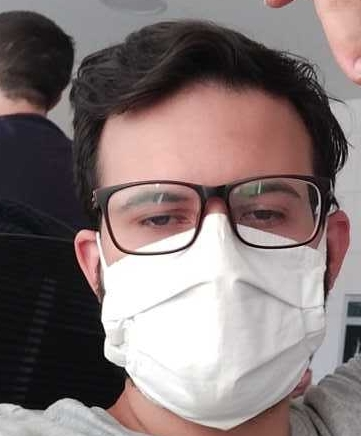

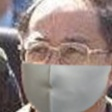

In [ ]:
from pytorch_metric_learning.utils.inference import FaissKNN

FaissKNN(reset_before=True,
            reset_after=True, 
            index_init_fn=None, 
            gpus=None)

knn_func = FaissKNN(gpus=[0])


distances, indices = knn_func(inferencia_embeddings, 1, query_embeddings, False)

print("Dist",distances.cpu().item())
print("Index",indices.cpu().item())


pathImg, index = inferencia_loader.dataset.imgs[0]
imInfere = transforms.ToPILImage()(torchvision.io.read_image(pathImg))
display(imInfere)

if(indices.cpu().item() < 12000):
  pathImg, index = train_loader.dataset.imgs[indices.cpu().item()]
else:
  pathImg, index = add_loader.dataset.imgs[indices.cpu().item()]

imIndex = transforms.ToPILImage()(torchvision.io.read_image(pathImg))
display(imIndex)

